In [1]:
from log_parser import parse_file, plot_data

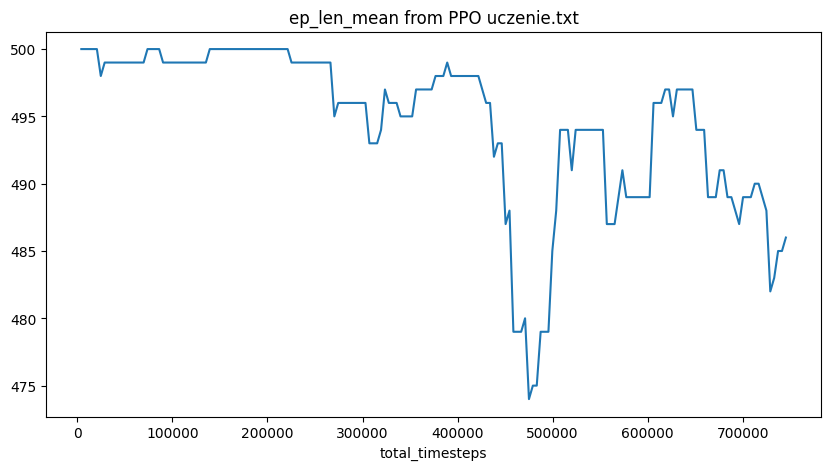

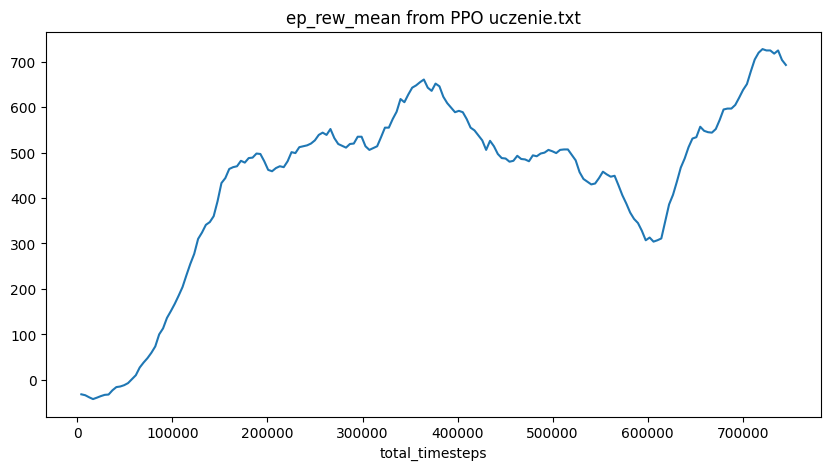

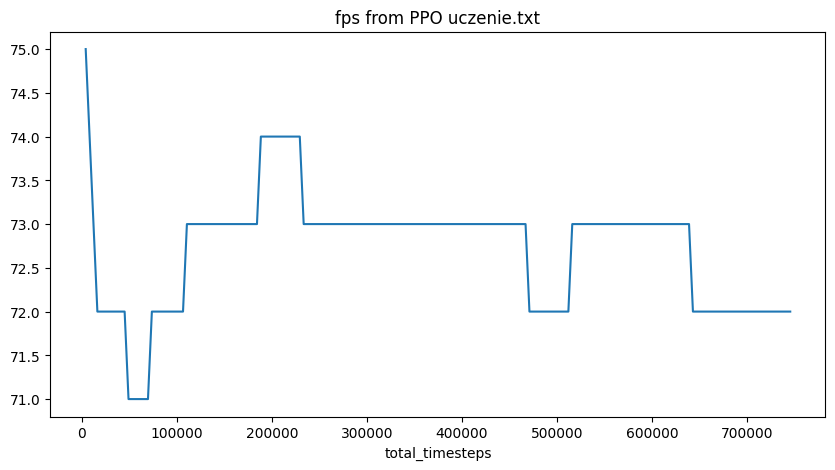

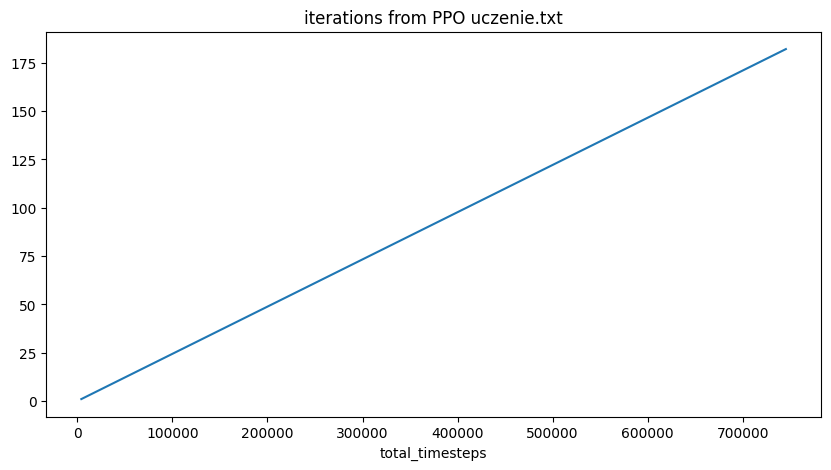

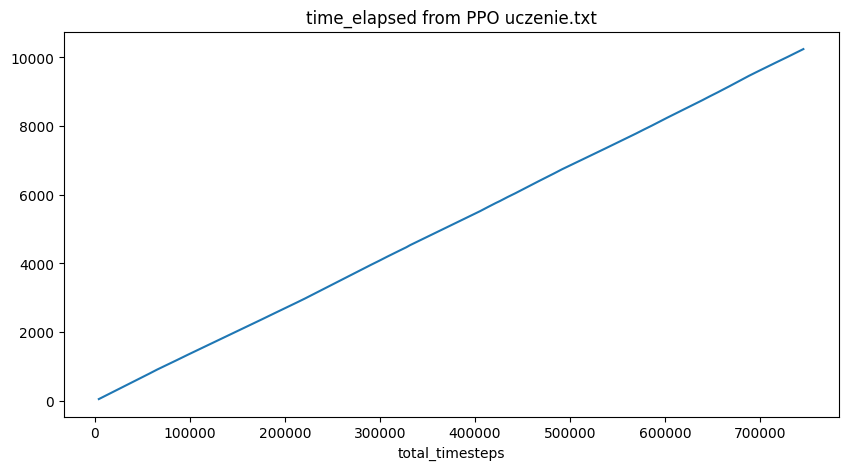

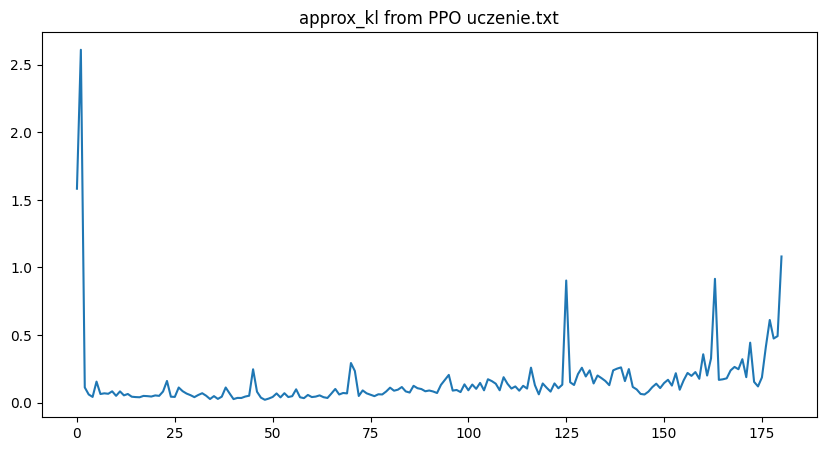

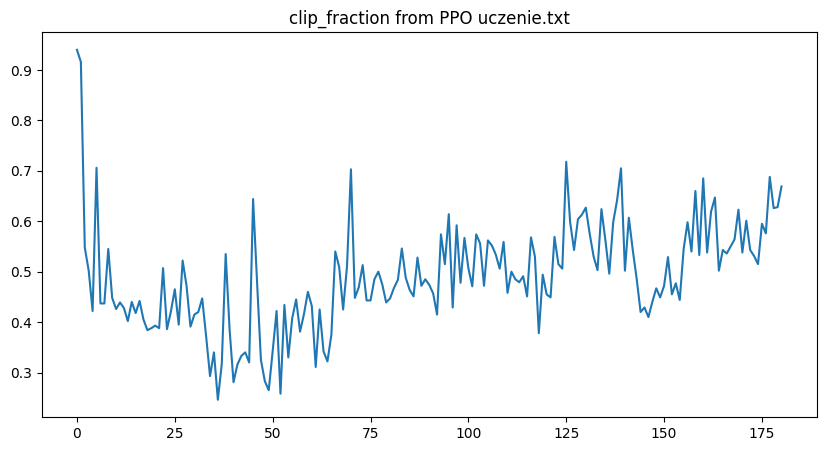

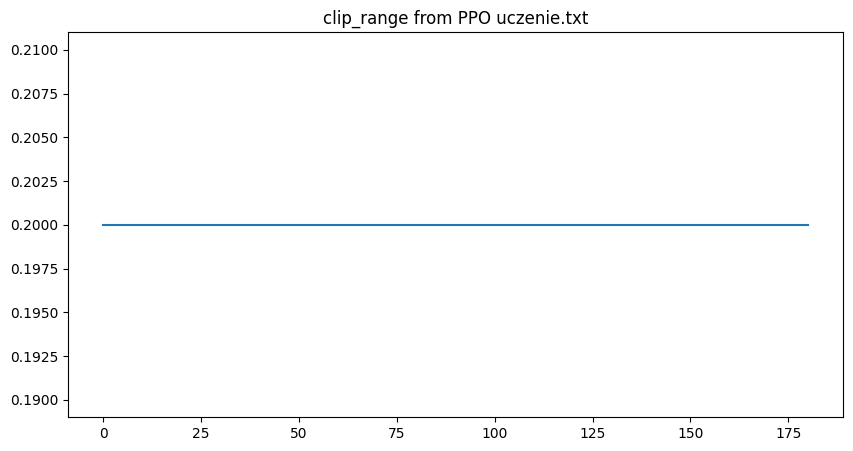

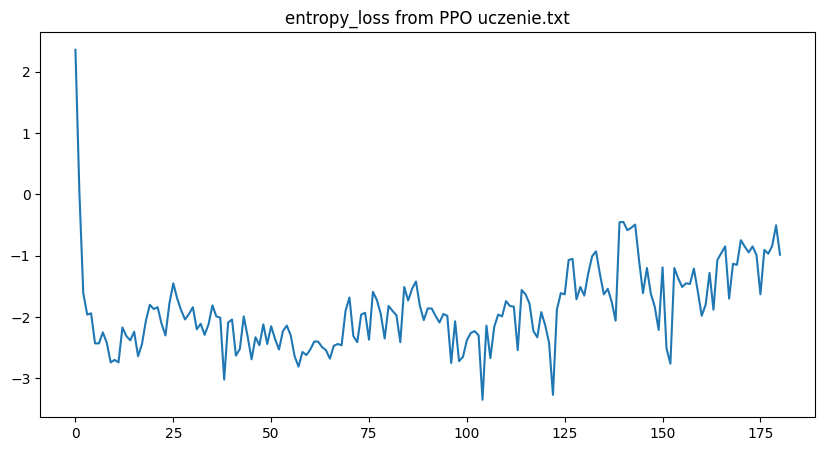

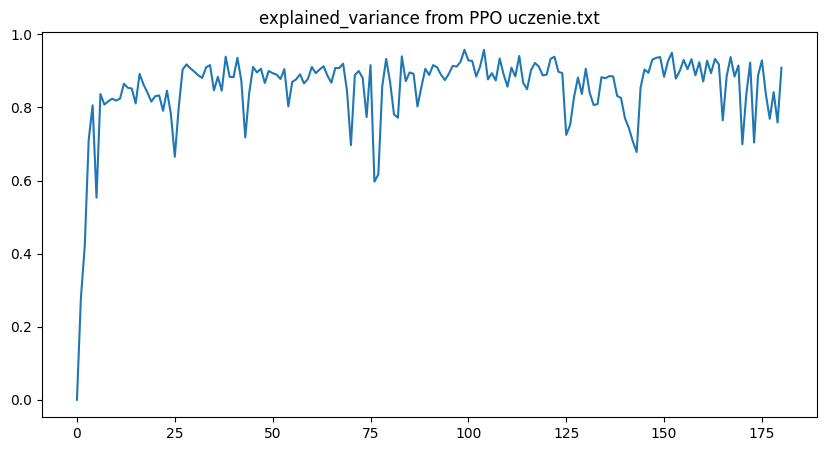

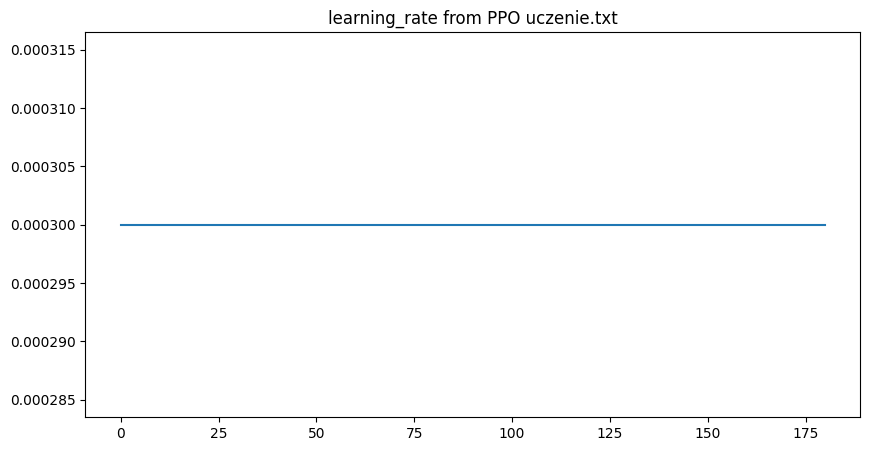

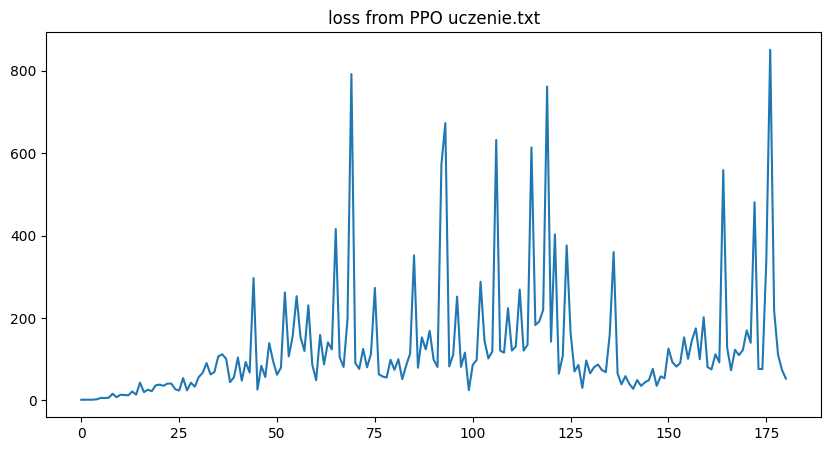

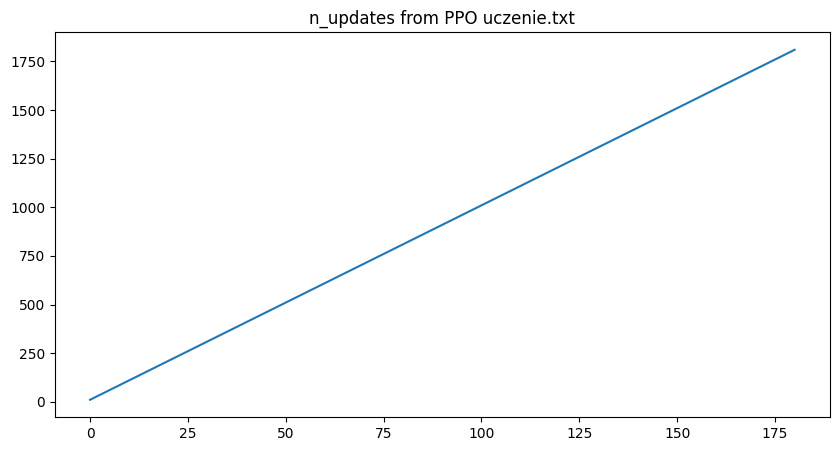

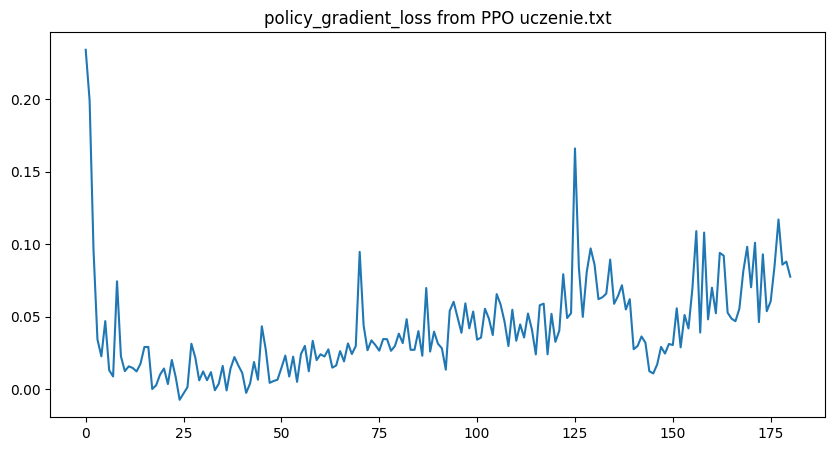

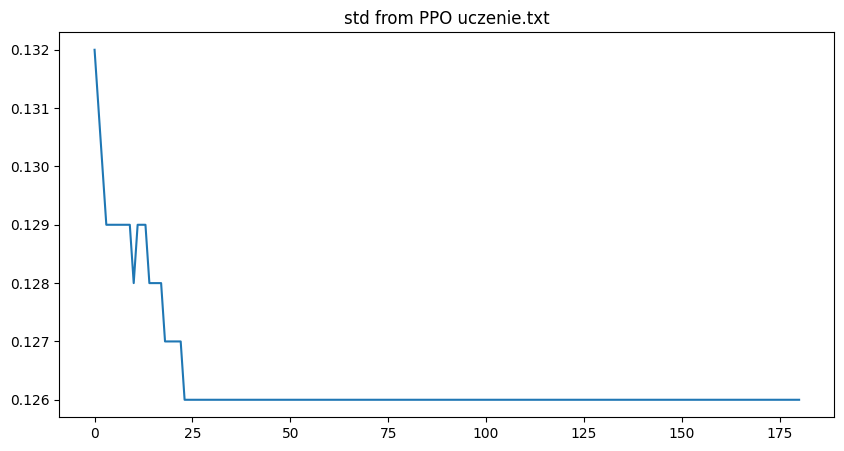

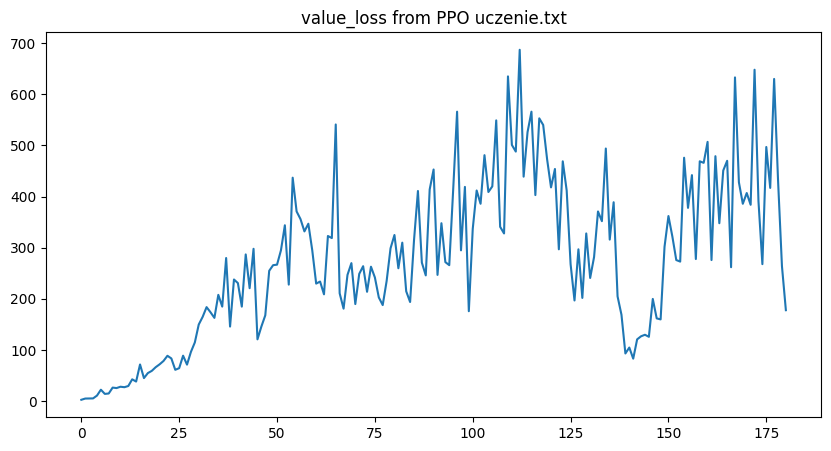

In [2]:
data = parse_file('PPO uczenie.txt')
plot_data(data, 'PPO uczenie.txt')

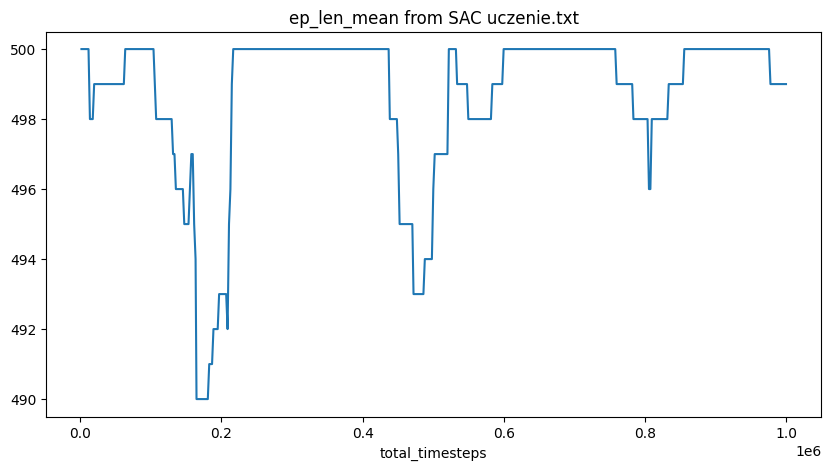

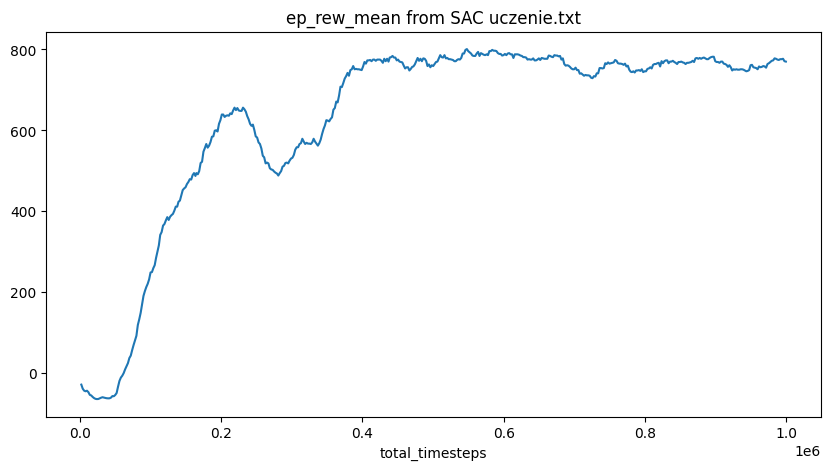

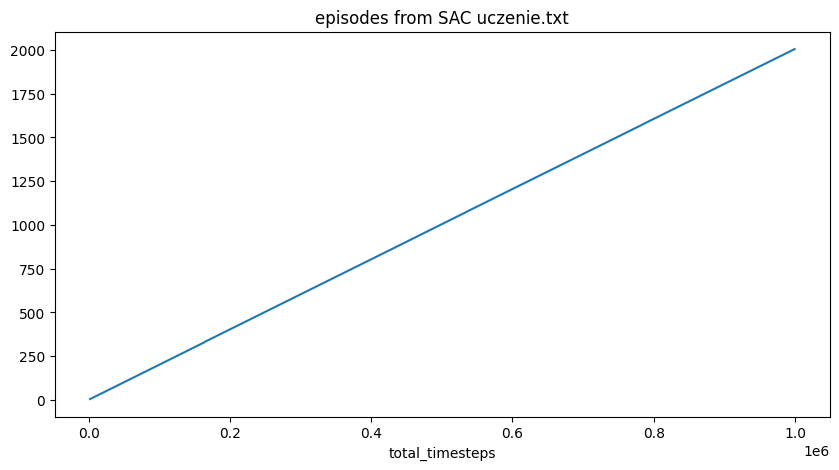

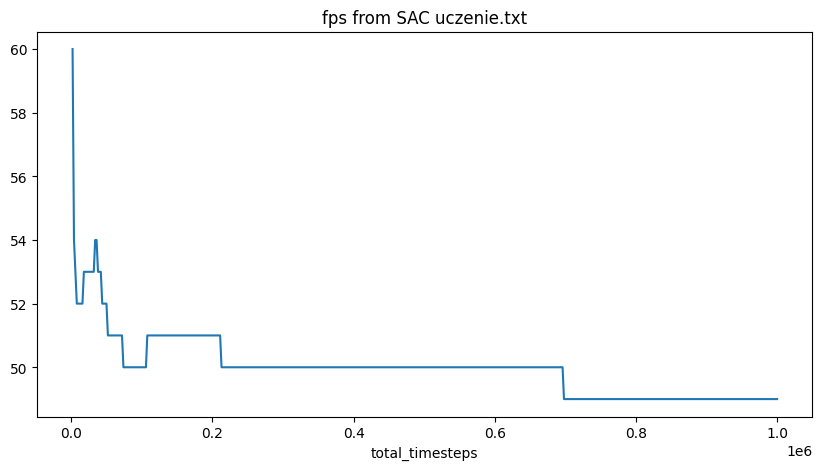

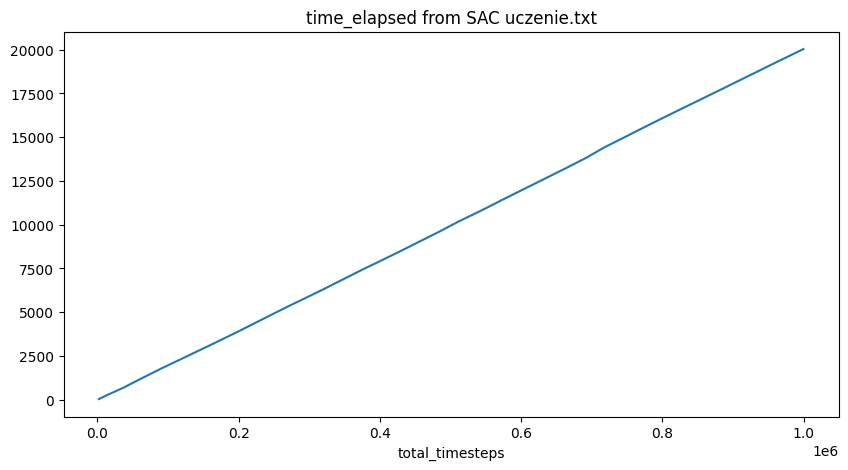

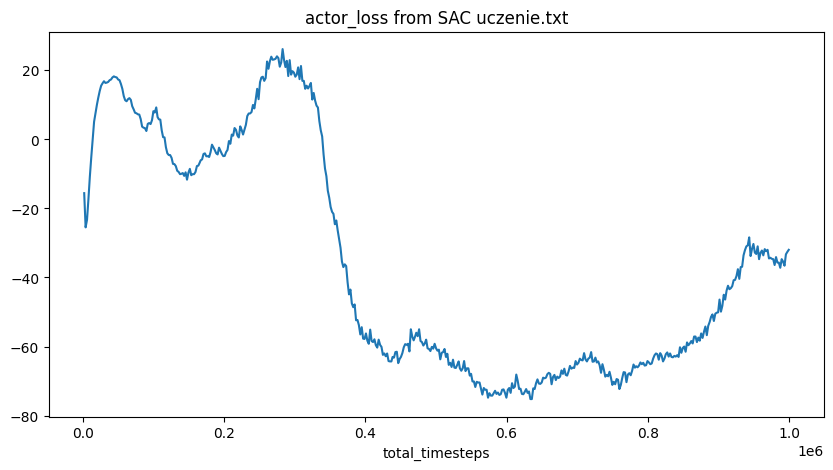

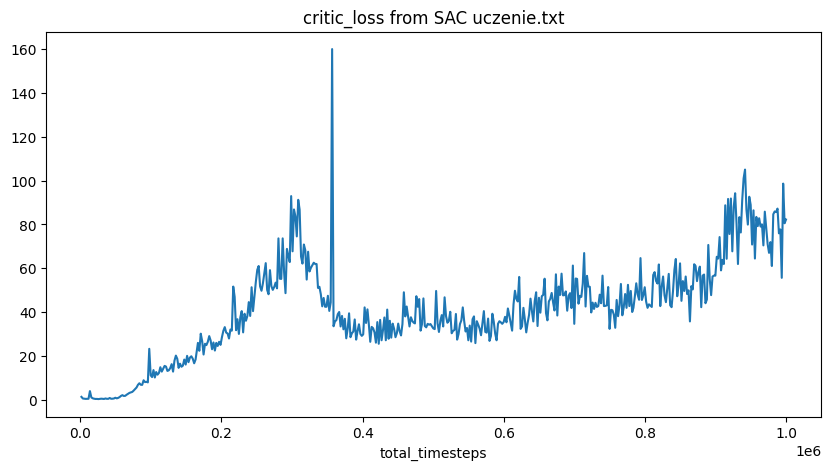

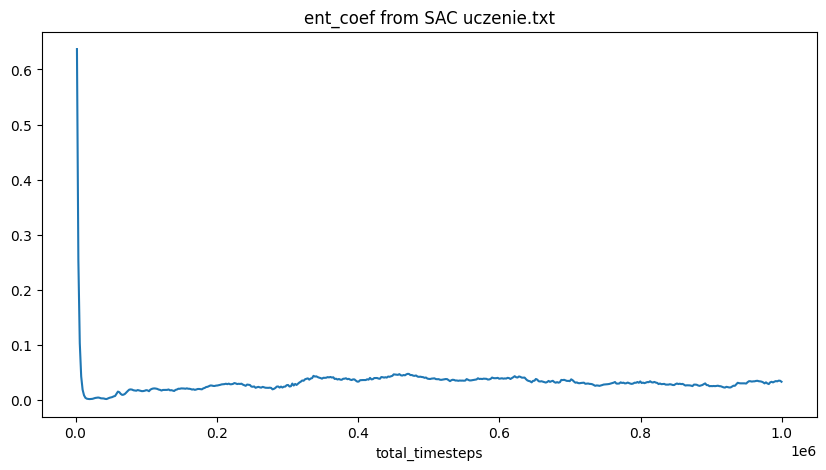

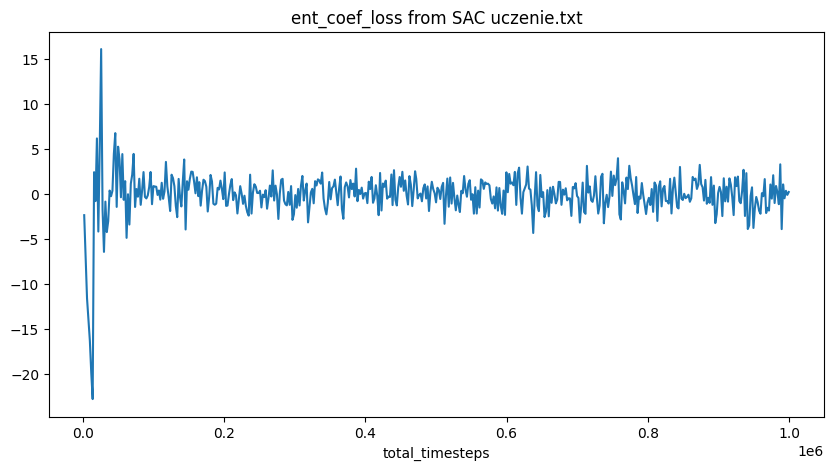

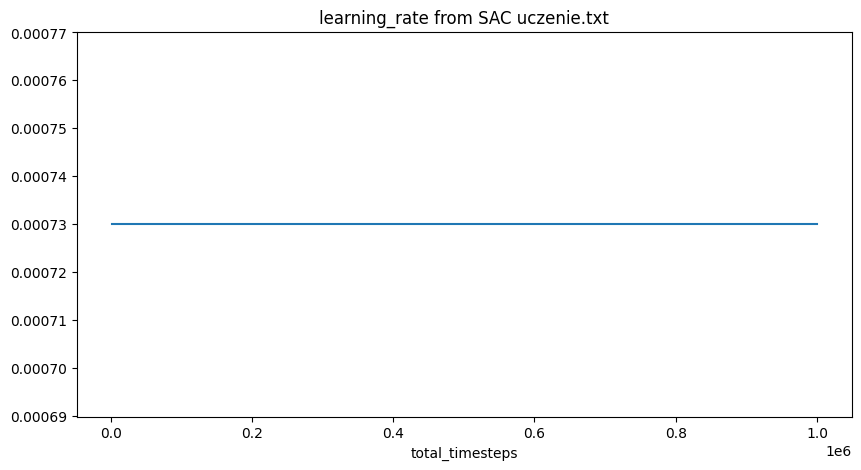

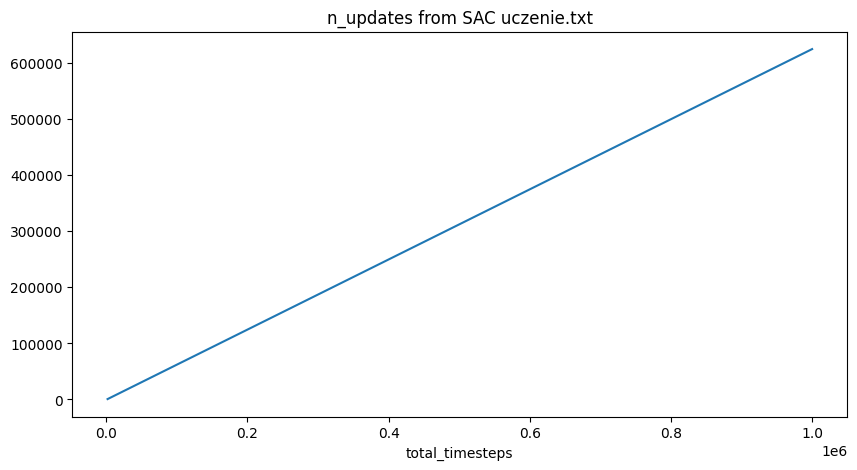

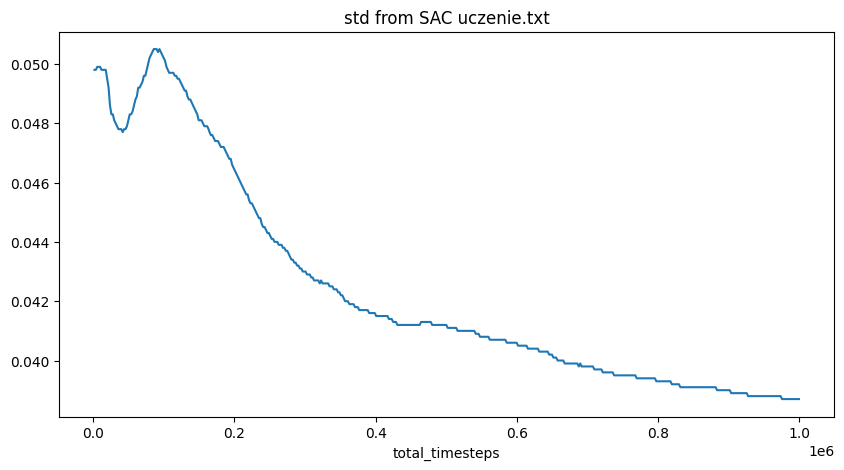

In [3]:
data = parse_file('SAC uczenie.txt')
plot_data(data, 'SAC uczenie.txt')